# Pipeline for High-z Radio Galaxies 14: Understanding application of full pipeline on confusion matrices

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
import squarify

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [12]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [13]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [14]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [15]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    values_format = ','
    if np.nanmax(confusion_matrix) <= 1:
        values_format = None
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=values_format)

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [16]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0.)

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [17]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [18]:
save_plot_flag      = False
load_models_flag    = True
use_second_z_model  = True
plot_cm_MQC_types   = False

In [19]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'

In [20]:
if used_area == 'HETDEX':
    used_subset = 'train_test'  # 'training', 'test', 'train_test', 'validation'

In [21]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [22]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [23]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [24]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [25]:
print(f'Using data from {used_area}')

Using data from S82


##### Random seed

In [26]:
seed                                = 42

Create features with class and combined redshift.

In [27]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Discard minor features.

In [28]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

For HETDEX, split data on training, test, validation.

In [29]:
if used_area == 'HETDEX':
    full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)]

In [30]:
if used_area == 'HETDEX':
    train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                       random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
    train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                       random_state=seed, stratify=train_test_df.loc[:, 'class'])
    print('Shape of used data in HETDEX')
    print('(Confirmed galaxies and AGN)')
    print('-' * 50)
    print(f'Full Dataset size:                  {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Training data:                      {train_df.shape}')
    print(f'Testing data:                       {test_df.shape}')
    print(f'Unseen Data For Validation:         {validation_df.shape}')
    print('-' * 50)

In [31]:
if used_area == 'HETDEX':
    print(f'Using {used_subset} data from HETDEX')
    selected_dataset = {'training': train_df, 'test': test_df, 'train_test': train_test_df, 'validation': validation_df}
    full_catalog_df = selected_dataset[used_subset]

---

### Load models

In [32]:
if load_models_flag:
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        # redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
        redshift_reg_2  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 + SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [33]:
threshold_AGN   = 0.3112  # 0.5, 0.3094 from ROC AUC in train+test, 0.3112 from PR curve
threshold_radio = 4.99972232e-01  # 0.5, 4.99972232e-01 from ROC AUC in train+test and PR curve

In [34]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [35]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [36]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

In [37]:
redshift_lim    = 3.7
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=8)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

In [38]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,369093.000000,369093.000000,369093.000000,369093.000000,3514.000000,369093.000000
mean,0.488563,0.635853,0.042835,0.260848,1.284949,1.816632
std,0.098904,0.481191,0.202485,0.439098,0.890670,0.727758
min,0.000000,0.000000,0.000000,0.000000,-0.002420,0.040300
25%,0.500000,0.000000,0.000000,0.000000,0.580100,1.431100
50%,0.500000,1.000000,0.000000,0.000000,1.166000,1.981900
75%,0.500000,1.000000,0.000000,1.000000,1.874500,2.147900
max,1.000000,1.000000,1.000000,1.000000,6.780000,5.645700


In [39]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class']      == 1) &\
                            np.array(full_catalog_df.loc[:, 'pred_radio']    == 1)
filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class']      == 1)
filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio']      == 1)
num_AGN_p               = np.sum(filter_AGN_p)
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0))
num_radio_p             = np.sum(filter_radio_p)
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

#### Add columns with classes as shown by TYPE column in MQC

MQC v7.4d says:

Legend of type/class:  
     ``Q = QSO, type-I broad-line core-dominated, 792372 of these.``  
     ``A = AGN, type-I Seyferts/host-dominated, 41983 of these.``  
     ``B = BL Lac type object, 2744 of these.``  
     ``L = lensed quasar extra image, only 66 of these in this optical data.``  
     ``K = NLQSO, type-II narrow-line core-dominated, 5798 of these.``  
     ``N = NLAGN, type-II Seyferts/host-dominated, 39366 of these.  Includes an``  
                ``unquantified residue of legacy NELGs/ELGs/LINERs.``  
     ``R = radio association displayed.``  
     ``X = X-ray association displayed.``  
     ``2 = double radio lobes displayed (declared by data-driven algorithm).``  

QSO candidates (type starting with ``R/X/2``)  
Fully classified object (type starting with ``Q/A/B/K/N/L``)

In [40]:
MQC_types = ['Q', 'A', 'B', 'K', 'N', 'L', 'R', 'X', '2']
for type_val in MQC_types:
    full_catalog_df[f'is_{type_val}'] = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)).astype(int)

### Create confusion matrices and scores for all individual TYPEs of sources

In [41]:
cm_mat_MQC_filts = {}
cm_mat_MQC       = {}
MCC_MQC          = {}
ACC_MQC          = {}
F1_MQC           = {}
Recall_MQC       = {}

In [42]:
cm_mat_AGN_filter       = np.array([[(np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class'] == 1.0))],\
                                    [(np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class'] == 1.0))]])

cm_mat_AGN_large_filter = np.array([[(np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class'] == 0.5)),\
                                     (np.array(full_catalog_df['class'] == 0)   & np.array(full_catalog_df['pred_class'] == 1.0))],\
                                    [(np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class'] == 0.5)),\
                                     (np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class'] == 1.0))],\
                                    [(np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                     (np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class'] == 0.5)),\
                                     (np.array(full_catalog_df['class'] == 1)   & np.array(full_catalog_df['pred_class'] == 1.0))]])

In [43]:
cm_mat_AGN        = np.array([[np.sum(cm_mat_AGN_filter[0, 0]),       np.sum(cm_mat_AGN_filter[0, 1])],\
                              [np.sum(cm_mat_AGN_filter[1, 0]),       np.sum(cm_mat_AGN_filter[1, 1])]])

cm_mat_AGN_large  = np.array([[np.sum(cm_mat_AGN_large_filter[0, 0]), np.sum(cm_mat_AGN_large_filter[0, 1]), np.sum(cm_mat_AGN_large_filter[0, 2])],\
                              [np.sum(cm_mat_AGN_large_filter[1, 0]), np.sum(cm_mat_AGN_large_filter[1, 1]), np.sum(cm_mat_AGN_large_filter[1, 2])],\
                              [np.sum(cm_mat_AGN_large_filter[2, 0]), np.sum(cm_mat_AGN_large_filter[2, 1]), np.sum(cm_mat_AGN_large_filter[2, 2])]])

#### Select sub-set to use (full, training, testing, validation)

In [44]:
for type_val in MQC_types:
    cm_mat_MQC_filts[type_val] = np.array([[(np.array(full_catalog_df[f'is_{type_val}'] == 0) & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                            (np.array(full_catalog_df[f'is_{type_val}'] == 0) & np.array(full_catalog_df['pred_class'] == 1.0))],\
                                           [(np.array(full_catalog_df[f'is_{type_val}'] == 1) & np.array(full_catalog_df['pred_class'] == 0.0)),\
                                            (np.array(full_catalog_df[f'is_{type_val}'] == 1) & np.array(full_catalog_df['pred_class'] == 1.0))]])
    cm_mat_MQC[type_val]       = np.array([[np.sum(cm_mat_MQC_filts[type_val][0, 0] * cm_mat_AGN_filter[0, 0]),\
                                            np.sum(cm_mat_MQC_filts[type_val][0, 1] * cm_mat_AGN_filter[0, 1])],\
                                           [np.sum(cm_mat_MQC_filts[type_val][1, 0] * cm_mat_AGN_filter[1, 0]),\
                                            np.sum(cm_mat_MQC_filts[type_val][1, 1] * cm_mat_AGN_filter[1, 1])]])

    MCC_MQC[type_val]          = MCC_from_CM(cm_mat_MQC[type_val])
    ACC_MQC[type_val]          = ACC_from_CM(cm_mat_MQC[type_val])
    F1_MQC[type_val]           = F1_from_CM(cm_mat_MQC[type_val])
    Recall_MQC[type_val]       = Recall_from_CM(cm_mat_MQC[type_val])

In [45]:
MCC_AGN_all      = MCC_from_CM(cm_mat_AGN)
ACC_AGN_all      = ACC_from_CM(cm_mat_AGN)
F1_AGN_all       = F1_from_CM(cm_mat_AGN)
Recall_AGN_all   = Recall_from_CM(cm_mat_AGN)

In [46]:
print('-' * 50)
print(f'Metrics for AGN detection in {used_area} dataset:')
if used_area == 'HETDEX':
    print(f'Subset used: {used_subset}')
print(f'F1-score is                          F1 = {F1_AGN_all:.4f}')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_all:.4f}')
print(f'Recall is                           TPR = {Recall_AGN_all:.4f}')
print(f'Accuracy is                         ACC = {ACC_AGN_all:.4f}')
print('-' * 50  + '\n')

--------------------------------------------------
Metrics for AGN detection in S82 dataset:
F1-score is                          F1 = 0.4457
Matthews Correlation Coefficient is MCC = 0.2803
Recall is                           TPR = 0.9105
Accuracy is                         ACC = 0.5208
--------------------------------------------------



In [47]:
if plot_cm_MQC_types:
    for type_val in MQC_types:
        fig             = plt.figure(figsize=(8,6))
        ax1             = fig.add_subplot(111)
        
        plot_conf_mat(cm_mat_MQC[type_val], title=f'TYPE = {type_val}', axin=ax1, display_labels=[f'Non-{type_val}', f'{type_val}'], log_stretch=True)
        save_filename = f'plots/confusion_matrix_AGN_{type_val}_{used_area}.pdf'
        if used_area == 'HETDEX':
            save_filename = f'plots/confusion_matrix_AGN_{type_val}_{used_area}_{used_subset}.pdf'
        if save_plot_flag:
            plt.savefig(save_filename, bbox_inches='tight')
        plt.show()

---

### Use squarify

In [48]:
sizes_types_full   = []  # full dataset, no confusion matrix
used_types_full    = []
list_types         = ['Q', 'A', 'B', 'L', 'K', 'N']
for type_val in list_types:
    n_elems = np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1))
    if n_elems == 0:
        continue
    used_types_full.append(type_val)
    sizes_types_full.append(np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1)))

In [49]:
color_ll   = plt.get_cmap('cet_CET_L8', len(used_types_full))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

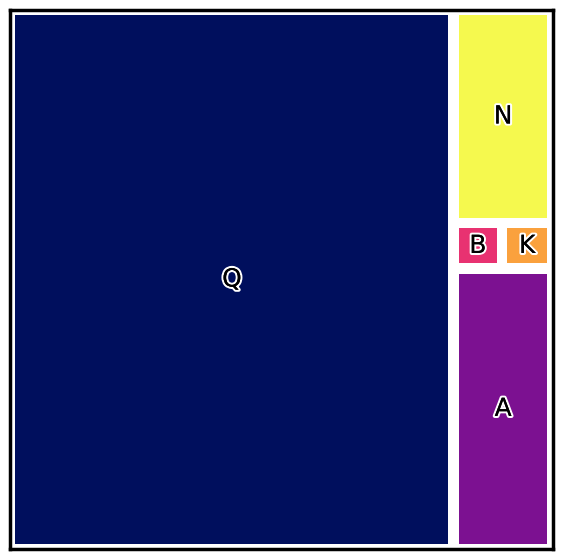

In [50]:
fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types_full, label=used_types_full, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

In [51]:
show_empty_flag = False

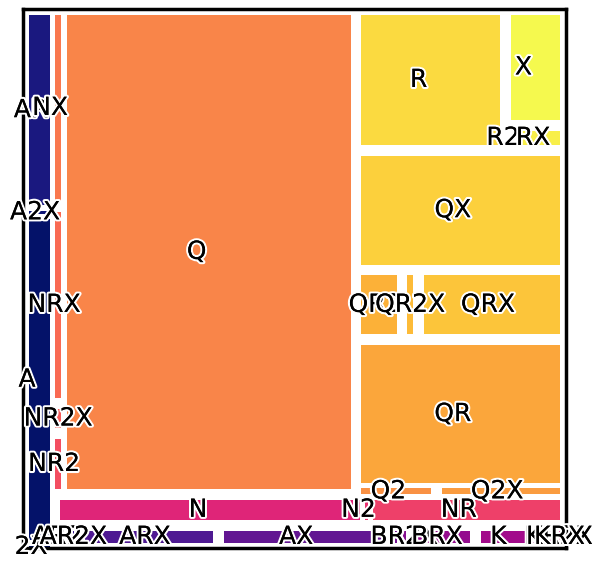

In [52]:
sizes_types   = []
list_types    = list(np.unique(full_catalog_df.loc[:, 'TYPE']))
if not show_empty_flag:
    list_types.remove('    ')
for type_val in list_types:
    sizes_types.append(np.sum(full_catalog_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)))

color_ll   = plt.get_cmap('cet_CET_L8', len(list_types))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

if show_empty_flag:
    list_types[:] = ['0   ' if x=='    ' else x for x in list_types]

fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types, label=list_types, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

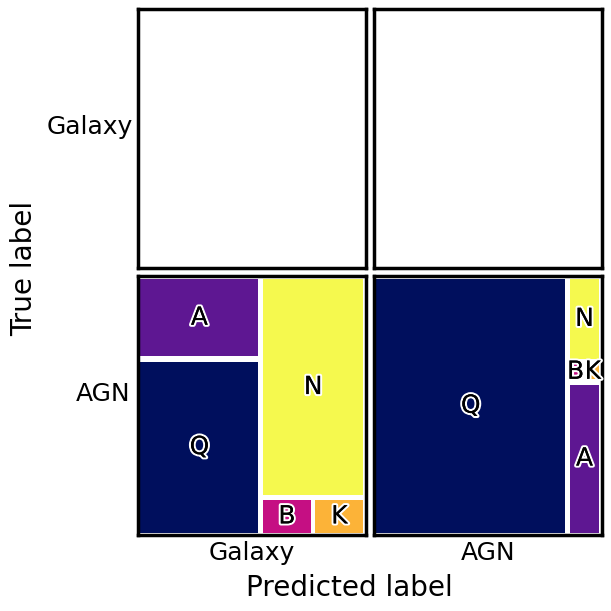

In [53]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['Q', 'A', 'B', 'L', 'K', 'N']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['Q', 'A', 'B', 'L', 'K', 'N']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1) & cm_mat_AGN_filter[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='left', x=0.4)
fig.supylabel('True label', fontsize=20, va='bottom', y=0.45)
# fig.suptitle('Predicted values', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/conf_matrix_treeplot_AGN_MQC_TYPE_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/conf_matrix_treeplot_AGN_MQC_TYPE_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

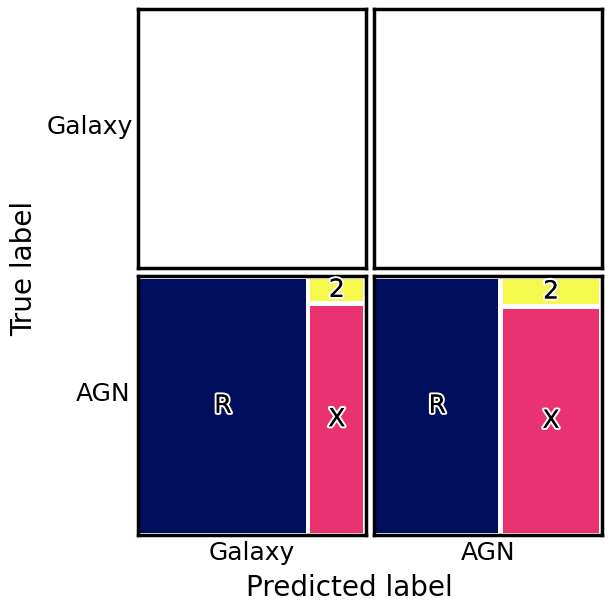

In [54]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['R', 'X', '2']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['R', 'X', '2']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(full_catalog_df[f'is_{type_val}'] == 1) & cm_mat_AGN_filter[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='left', x=0.4)
fig.supylabel('True label', fontsize=20, va='bottom', y=0.45)
# fig.suptitle('Predicted values', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/conf_matrix_treeplot_AGN_MQC_TYPE_assoc_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/conf_matrix_treeplot_AGN_MQC_TYPE_assoc_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

### Additional plots for confusion matrix

In [55]:
mag_cols_lim = {'W1mproPM': 20.13, 'W2mproPM': 19.81, 'Sint_LOFAR': 17.52, 'Total_flux_VLASS': 15.21,\
                    'TotalFlux_LoLSS': 12.91, 'Stotal_TGSS': 11.18, 'Fint_VLAS82': 17.86,\
                    'Flux_COSMOSVLA3': 21.25, 'W1mag': 19.6, 'W2mag': 19.34, 'W3mag': 16.67,\
                    'W4mag': 14.62, 'gmag': 23.3, 'rmag': 23.2, 'imag': 23.1, 'zmag': 22.3,\
                    'ymag': 21.4, 'FUVmag': 20.0, 'NUVmag': 21.0, 'FEP': 57.9, 'Jmag': 17.45,\
                    'Hmag': 17.24, 'Kmag': 16.59}  # Proper (5-sigma) limits

for key in mag_cols_lim:
    mag_cols_lim[key] = np.float32(mag_cols_lim[key])

In [56]:
bands_plot = ['FUVmag', 'NUVmag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag',
              'Hmag', 'Kmag', 'W1mproPM', 'W2mproPM', 'W1mag', 'W2mag', 'W3mag', 'W4mag']

In [57]:
mag_cols_names   = {'W1mproPM': 'W1 (CW)', 'W2mproPM': 'W2 (CW)', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3 (AW)', 'W4mag': 'W4 (AW)', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

Temporary plots, to obtain density maps of full dataset (all confirmed).

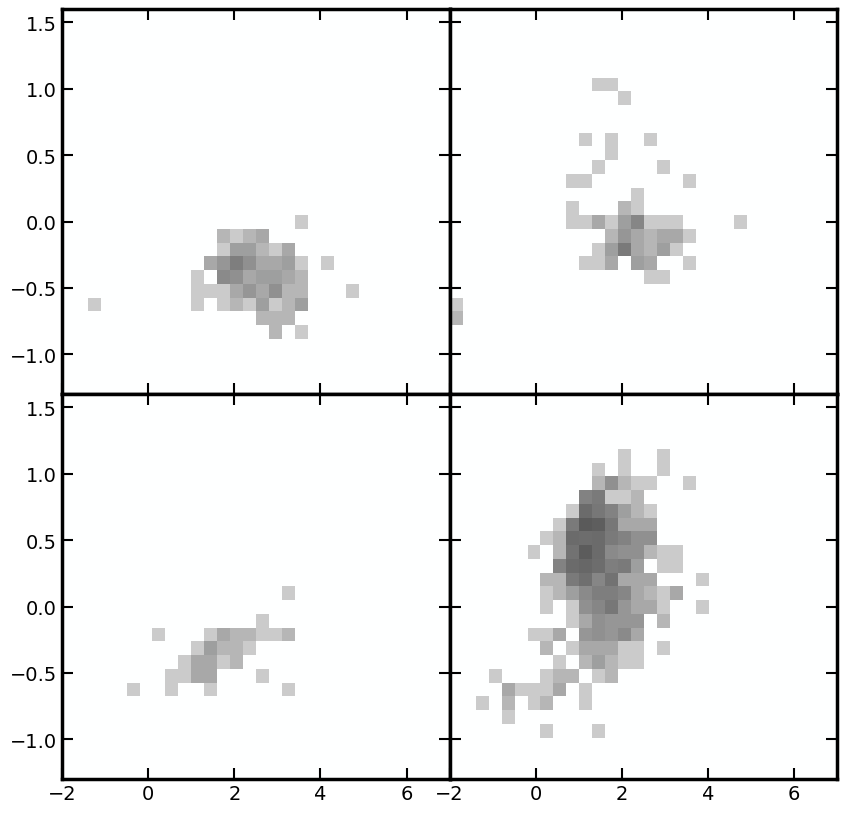

In [58]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(5 * n_cols, 5 * n_rows), constrained_layout=False)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs_temp        = {}

filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])
filt_exist   = np.isfinite(full_catalog_df.loc[:, 'W1mproPM']) &\
                np.isfinite(full_catalog_df.loc[:, 'W2mproPM']) &\
                np.isfinite(full_catalog_df.loc[:, 'W3mag'])
filt_colours = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])
dens_CM_AGN  = {}

norm_dens = ImageNormalize(vmin=0, vmax=4e2, stretch=LogStretch())

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # kwargs = {}
    # if count != 0:
    #     kwargs = {'sharex': axs_temp[0], 'sharex': axs_temp[0]}
    # axs_temp[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count == 0:
        axs_temp[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count != 0:
        axs_temp[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density',\
                                          sharex=axs_temp[0], sharey=axs_temp[0])
        
    x_axis_dens = (full_catalog_df[cm_mat_AGN_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W2mproPM'] -\
                   full_catalog_df[cm_mat_AGN_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W3mag'])
    y_axis_dens = (full_catalog_df[cm_mat_AGN_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W1mproPM'] -\
                   full_catalog_df[cm_mat_AGN_filter[tuple(idx_ax)] * filt_colours * filt_exist]['W2mproPM'])
    if not ((len(x_axis_dens) == 0) | (len(y_axis_dens) == 0)):
        dens_CM_AGN[count] = axs_temp[count].scatter_density(x_axis_dens, y_axis_dens,\
                                                             cmap=plt.get_cmap('cet_gray_r'), zorder=0,\
                                                             dpi=9, alpha=1.0, norm=norm_dens)
    if ((len(x_axis_dens) == 0) | (len(y_axis_dens) == 0)):
        dens_CM_AGN[count] = None
    if count == 0:
        x_lims = (axs_temp[count].get_xlim()[0] - 0.2, axs_temp[count].get_xlim()[1] + 0.2)
        y_lims = (axs_temp[count].get_ylim()[0] - 0.2, axs_temp[count].get_ylim()[1] + 0.2)
        
    axs_temp[count].tick_params(which='both', top=True, right=True,\
                            bottom=True, left=True, direction='in')
    axs_temp[count].tick_params(axis='both', which='major', labelsize=14)
    axs_temp[count].tick_params(axis='both', which='minor', labelsize=14)
    axs_temp[count].tick_params(which='major', length=8, width=1.5)
    axs_temp[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs_temp[count].spines.values(), linewidth=2.5)
    plt.setp(axs_temp[count].spines.values(), linewidth=2.5)

plt.setp(axs_temp[0].get_xticklabels(), visible=False)
plt.setp(axs_temp[1].get_yticklabels(), visible=False)
plt.setp(axs_temp[1].get_xticklabels(), visible=False)
plt.setp(axs_temp[3].get_yticklabels(), visible=False)

axs_temp[0].set_xlim(left=-2, right=7)
axs_temp[0].set_ylim(bottom=-1.3, top=1.6)
axs_temp[0].set_aspect('auto', 'datalim')
#plt.close(fig_temp)

In [59]:
num_contour_levels = 5
type_of_levels     = 'log'  # 'log', 'linear'
print('For the following plot, contour levels will be located at:')
if type_of_levels  == 'linear':
    print(np.linspace(0.5, 10**(np.floor(np.log10(np.nanmax([dens_CM_AGN[key].get_array() for key in dens_CM_AGN if dens_CM_AGN[key] != None])))), num_contour_levels))
if type_of_levels  == 'log':
    print(np.logspace(np.log10(0.5), np.floor(np.log10(np.nanmax([dens_CM_AGN[key].get_array() for key in dens_CM_AGN if dens_CM_AGN[key] != None]))), num_contour_levels))

For the following plot, contour levels will be located at:
[ 0.5         1.05737126  2.23606798  4.72870805 10.        ]


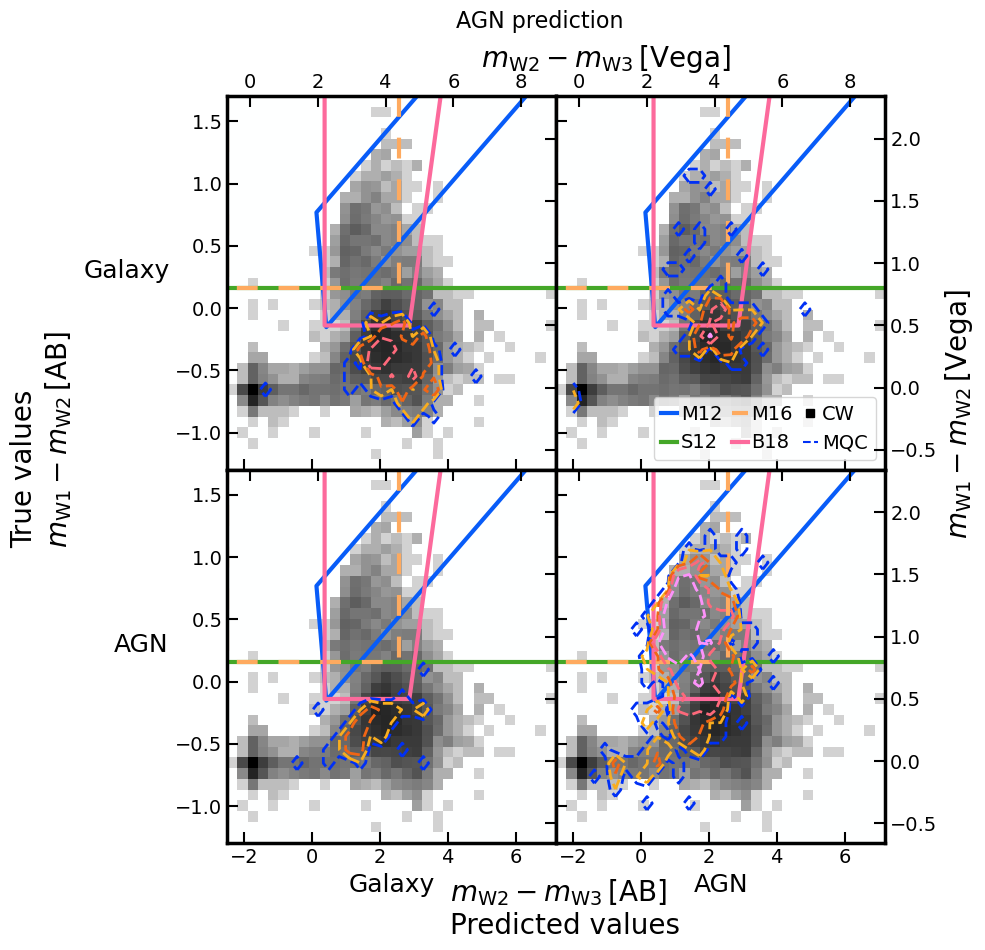

In [60]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
               np.array(full_catalog_df.loc[:, 'W2mproPM']  != mag_cols_lim['W2mproPM']) &\
               np.array(full_catalog_df.loc[:, 'W3mag']     != mag_cols_lim['W3mag'])


filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])

dens_plot_data_x = (full_catalog_df.loc[filt_colours, 'W2mproPM'] -\
                    full_catalog_df.loc[filt_colours, 'W3mag'])[filt_plot]
dens_plot_data_y = (full_catalog_df.loc[filt_colours, 'W1mproPM'] -\
                    full_catalog_df.loc[filt_colours, 'W2mproPM'])[filt_plot]

dens_plts = {}
cont_plts = {}

AB_lims_x = (-2.5, 7.2)
AB_lims_y = (-1.3, 1.7)

if type_of_levels  == 'linear':
    contour_levels = np.linspace(0.5,\
                                 10**(np.floor(np.log10(np.nanmax([dens_CM_AGN[key].get_array() for key in dens_CM_AGN if dens_CM_AGN[key] != None])))),\
                                 num_contour_levels)
if type_of_levels  == 'log':
    contour_levels = np.logspace(np.log10(0.5),\
                                 np.floor(np.log10(np.nanmax([dens_CM_AGN[key].get_array() for key in dens_CM_AGN if dens_CM_AGN[key] != None]))),\
                                 num_contour_levels)
# contour_levels = [0.5, 1.5, 4.5, 13.5, 40, 80, 100]

norm_val  = mcolors.CenteredNorm(vcenter=0.5)
norm_dens = ImageNormalize(vmin=0, vmax=500, stretch=LogStretch())
norm_cont = ImageNormalize(vmin=contour_levels[0], vmax=contour_levels[-1], stretch=LogStretch())

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density',\
                                          sharex=axs[0], sharey=axs[0])
    
    dens_plts[count] = axs[count].scatter_density(dens_plot_data_x,\
                                                  dens_plot_data_y,\
                                                  cmap=plt.get_cmap('cet_gray_r'), zorder=0, dpi=10,\
                                                  norm=norm_dens, alpha=1.0)
    if dens_CM_AGN[count] != None:
        xx_agn = np.linspace(dens_CM_AGN[count].get_extent()[0],\
                             dens_CM_AGN[count].get_extent()[1], np.shape(dens_CM_AGN[count].get_array())[1])
        yy_agn = np.linspace(dens_CM_AGN[count].get_extent()[2],\
                             dens_CM_AGN[count].get_extent()[3], np.shape(dens_CM_AGN[count].get_array())[0])
        
        cont_plts[count] = axs[count].contour(xx_agn, yy_agn, np.flipud(dens_CM_AGN[count].get_array()),\
                                              levels=contour_levels, linewidths=2.0, cmap=plt.get_cmap('cet_CET_R1'),\
                                              linestyles='dashed', zorder=3, norm=norm_cont)
    
    # x_Vega   = np.array(axs[0].get_xlim()) - 3.339 + 5.174  # Vega
    # y_Vega   = np.array(axs[0].get_ylim()) - 2.699 + 3.339  # Vega
    x_Vega   = np.array(AB_lims_x) - 3.339 + 5.174  # Vega
    y_Vega   = np.array(AB_lims_y) - 2.699 + 3.339  # Vega
    # Mateos+2012
    y_M12_a = 0.315 * (x_Vega) + 0.791
    y_M12_b = 0.315 * (x_Vega) - 0.222
    y_M12_c = -3.172 * (x_Vega) + 7.624
    # Stern+2012
    # Toba+2014
    # Mingo+2016
    # # Assef+2018 (75% completeness)
    # y_A18_75 = 0.530 * np.exp(0.183 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.76)**2)
    # # Assef+2018 (90% completeness)
    # y_A18_90 = 0.662 * np.exp(0.232 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.97)**2)
    # Blecha+2018
    points_M12 = np.array([[x_Vega[-1], 1.9596, 2.2501, x_Vega[-1]], [y_M12_a[-1], 1.4083, 0.4867, y_M12_b[-1]]])
    points_M16 = np.array([[4.4, 4.4, x_Vega[0], x_Vega[0]], [y_Vega[-1], 0.8, 0.8, y_Vega[-1]]])
    points_B18 = np.array([[2.2, 2.2, 4.7, (y_Vega[-1] + 8.9) * 0.5], [y_Vega[-1], 0.5, 0.5, y_Vega[-1]]])
    
    axs[count].plot(points_M12[0] + 3.339 - 5.174, points_M12[1] + 2.699 - 3.339, label='M12',\
                    c=plt.get_cmap('cet_CET_R3')(0.0), zorder=2, lw=3)
    axs[count].axhline(y=0.8 + 2.699 - 3.339, label='S12', c=plt.get_cmap('cet_CET_R3')(0.2),\
                       zorder=2, lw=3)
    axs[count].plot(points_M16[0] + 3.339 - 5.174, points_M16[1] + 2.699 - 3.339, label='M16',\
                    c=plt.get_cmap('cet_CET_R3')(0.6), zorder=2, lw=3, ls=(0, (5, 5)))
    axs[count].plot(points_B18[0] + 3.339 - 5.174, points_B18[1] + 2.699 - 3.339, label='B18',\
                    c=plt.get_cmap('cet_CET_R3')(0.75), zorder=2, lw=3)
    
    
    axs_twinx[count] = axs[count].twinx()
    # axs_twinx[count].set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339))
    # axs_twinx[count].set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
    axs_twinx[count].tick_params(which='both', top=False, right=True, direction='in')
    axs_twinx[count].tick_params(which='both', bottom=False, left=False, direction='in')
    axs_twinx[count].tick_params(axis='both', which='major', labelsize=14)
    axs_twinx[count].tick_params(which='major', length=8, width=1.5)
    axs_twinx[count].tick_params(which='minor', length=4, width=1.5)
    # axs_twinx[count].set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20)
    
    axs_twiny[count] = axs[count].twiny()
    # axs_twiny[count].set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339 + 5.174))
    # axs_twiny[count].set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
    axs_twiny[count].tick_params(which='both', top=True, right=False, direction='in')
    axs_twiny[count].tick_params(which='both', bottom=False, left=False, direction='in')
    axs_twiny[count].tick_params(axis='both', which='major', labelsize=14)
    axs_twiny[count].tick_params(which='major', length=8, width=1.5)
    axs_twiny[count].tick_params(which='minor', length=4, width=1.5)
    # axs_twiny[count].set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20)
    
    
    

    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_R1')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=AB_lims_x[0], right=AB_lims_x[1])
axs[0].set_ylim(bottom=AB_lims_y[0], top=AB_lims_y[1])
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)

plt.setp(axs_twiny[2].get_xticklabels(), visible=False)
plt.setp(axs_twiny[3].get_xticklabels(), visible=False)

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs_twinx[count].set_ylim(tuple(np.array(axs[0].get_ylim()) - 2.699 + 3.339))
    axs_twiny[count].set_xlim(tuple(np.array(axs[0].get_xlim()) - 3.339 + 5.174))

axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

axs_twinx[1].set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20, y=0.15)
axs_twiny[0].set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20, x=1.15)

axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.46, y=0.05)
fig.supylabel('True values\n$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', fontsize=20,  y=0.55)
fig.suptitle('AGN prediction', fontsize=16, x=0.55)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/WISE_colour_colour_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/WISE_colour_colour_conf_matrix_AGN_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

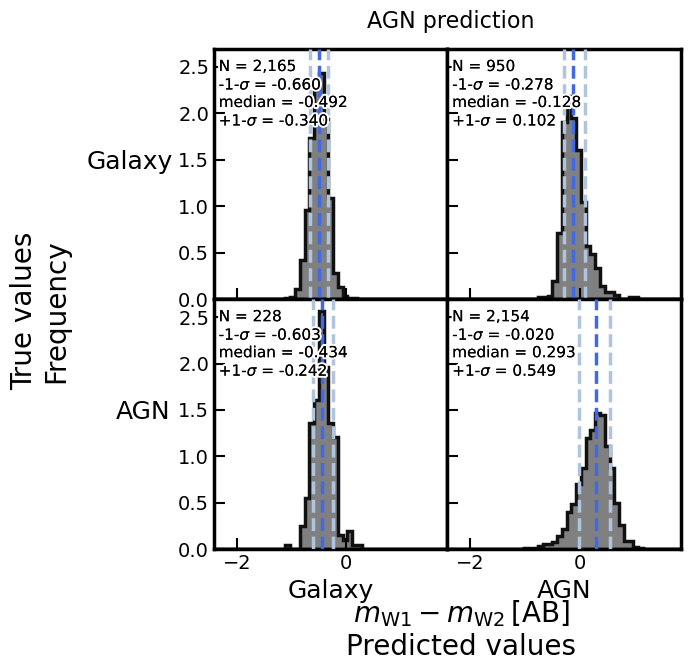

In [61]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])

filt_colour  = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM'])

filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])


min_bin   = (full_catalog_df.loc[:, 'W1mproPM'] -\
             full_catalog_df.loc[:, 'W2mproPM']).min()
max_bin   = (full_catalog_df.loc[:, 'W1mproPM'] -\
             full_catalog_df.loc[:, 'W2mproPM']).max()
n_bins    = 50
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[cm_mat_AGN_filter[tuple(idx_ax)] * filt_plot * filt_colour, 'w1_w2']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True)
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle('AGN prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/w1_w2_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/w1_w2_hist_conf_matrix_AGN_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

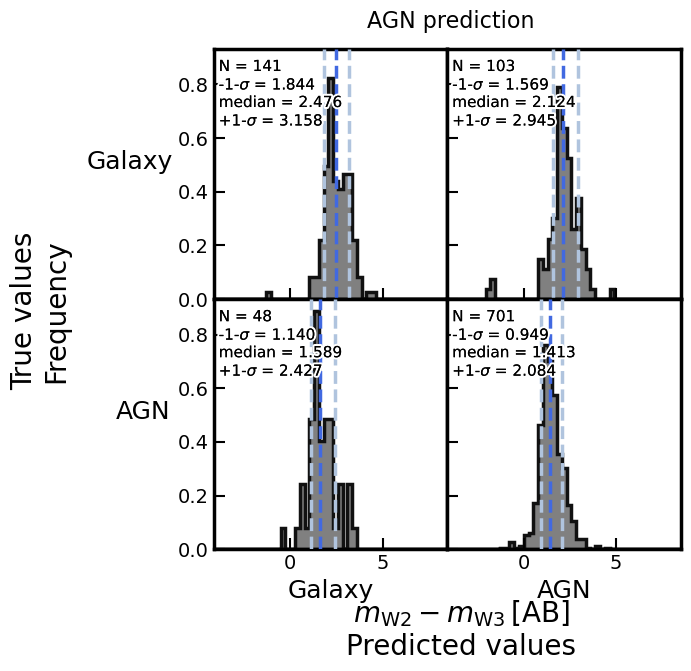

In [62]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag']    != mag_cols_lim['W3mag'])

filt_colour  = np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_df.loc[:, 'W3mag']   != mag_cols_lim['W3mag'])

filt_plot = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])


min_bin   = (full_catalog_df.loc[:, 'W2mproPM'] -\
             full_catalog_df.loc[:, 'W3mag']).min()
max_bin   = (full_catalog_df.loc[:, 'W2mproPM'] -\
             full_catalog_df.loc[:, 'W3mag']).max()
n_bins    = 50
hist_bins = np.linspace(min_bin, max_bin, n_bins)


dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[cm_mat_AGN_filter[tuple(idx_ax)] * filt_plot * filt_colour, 'w2_w3']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True)
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle('AGN prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/w2_w3_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/w2_w3_hist_conf_matrix_AGN_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

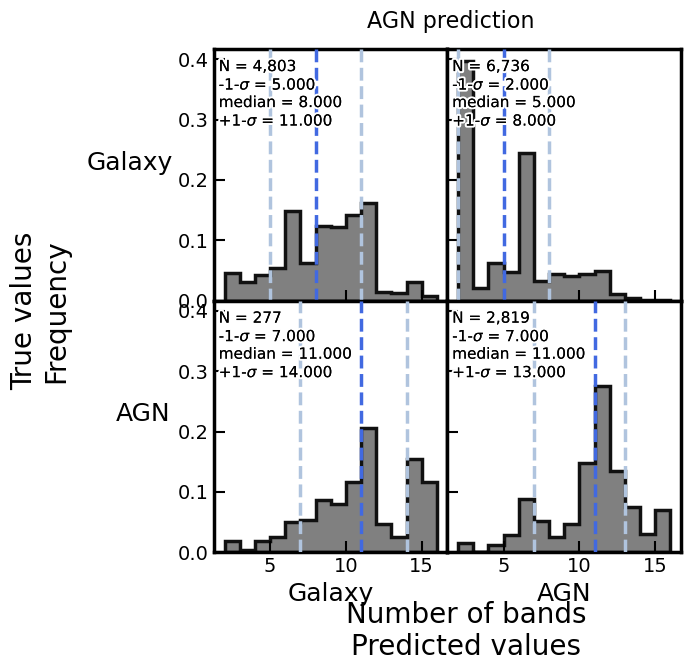

In [63]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

min_bin   = full_catalog_df.loc[:, 'band_num'].min()
max_bin   = full_catalog_df.loc[:, 'band_num'].max()
n_bins    = max_bin - min_bin + 1
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[cm_mat_AGN_filter[tuple(idx_ax)], 'band_num']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True, align='mid')
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
# axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('Number of bands\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle('AGN prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/band_num_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/band_num_hist_conf_matrix_AGN_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

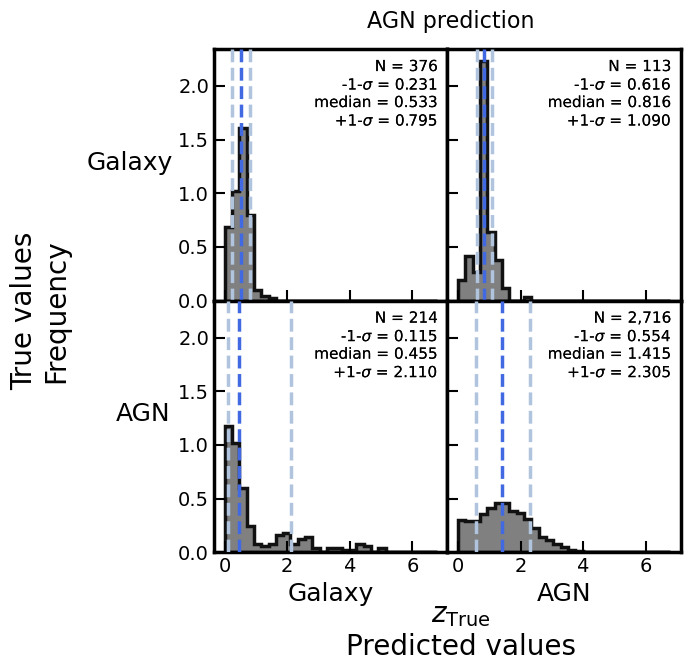

In [64]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

min_bin   = full_catalog_df.loc[:, 'Z'].min()
max_bin   = full_catalog_df.loc[:, 'Z'].max()
n_bins    = 30
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_df.loc[cm_mat_AGN_filter[tuple(idx_ax)], 'Z']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True, align='mid')
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.96, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='right', va='top', path_effects=pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
# axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel('Galaxy', fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel('Galaxy', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$z_{\mathrm{True}}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle('AGN prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'plots/redshift_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/redshift_hist_conf_matrix_AGN_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()

In [65]:
cm_mat_AGN_radio_det = np.array([[np.sum(cm_mat_AGN_filter[tuple([0, 0])] * np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)) /\
                                  np.sum(cm_mat_AGN_filter[tuple([0, 0])]),\
                                  np.sum(cm_mat_AGN_filter[tuple([0, 1])] * np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)) /\
                                  np.sum(cm_mat_AGN_filter[tuple([0, 1])])],\
                                 [np.sum(cm_mat_AGN_filter[tuple([1, 0])] * np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)) /\
                                  np.sum(cm_mat_AGN_filter[tuple([1, 0])]),\
                                  np.sum(cm_mat_AGN_filter[tuple([1, 1])] * np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)) /\
                                  np.sum(cm_mat_AGN_filter[tuple([1, 1])])]])

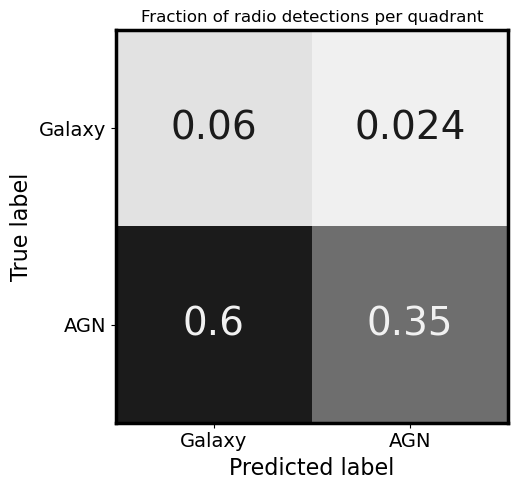

In [66]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_AGN_radio_det, 'Fraction of radio detections per quadrant', ax1,\
                 display_labels=['Galaxy', 'AGN'])
if save_plot_flag:
    save_filename = f'plots/confusion_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'plots/confusion_matrix_AGN_{used_area}_{used_subset}.pdf'
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()